<h2>Import Libraries</h2>

In [1]:
import os 
import cv2
import dlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from scipy.spatial import distance
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

from sklearn.metrics import classification_report, confusion_matrix

<h2>Load Dataset</h2>

In [3]:
DATASET_DIR = r"C:\Users\Anuj\OneDrive\Desktop\Drowsiness Dataset\mrleyedataset"
MODEL_PATH = r"C:\Users\Anuj\OneDrive\Desktop\Drowsiness Dataset/models/cnn_eye_model.h5"
IMG_SIZE = 24
BATCH_SIZE = 32
EPOCHS = 15

EAR_THRESHOLD = 0.25
DROWSY_FRAMES = 30

<h2>Data Augmentation</h2>

In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.3),
    tf.keras.layers.RandomFlip("horizontal"),
])


train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR),
    image_size=(24, 24),
    color_mode="grayscale",
    batch_size=32,
    label_mode="binary",
    validation_split=0.2,
    subset="training",
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR),
    image_size=(24, 24),
    color_mode="grayscale",
    batch_size=32,
    label_mode="binary",
    validation_split=0.2,
    subset="validation",
    seed=42
)

Found 27200 files belonging to 2 classes.
Using 21760 files for training.
Found 27200 files belonging to 2 classes.
Using 5440 files for validation.


<h2>CNN Model</h2>

In [5]:
model = Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,1)),
    MaxPooling2D(2,2),

    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.4),
    Dense(1,activation='sigmoid')
])

model.compile(
    optimizer=Adam(0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 22, 22, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 9, 9, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 2, 2, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,953 (492.00 KB)

 Trainable params: 125,953 (492.00 KB)

 Non-trainable params: 0 (0.00 B)

<h2>Training</h2>

In [6]:
callbacks=[
    EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True),
    ModelCheckpoint(MODEL_PATH,save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/15
679/680 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6446 - loss: 0.7337 

680/680 ━━━━━━━━━━━━━━━━━━━━ 53s 75ms/step - accuracy: 0.7191 - loss: 0.5583 - val_accuracy: 0.8257 - val_loss: 0.3796
Epoch 2/15
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8474 - loss: 0.3558 

680/680 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8604 - loss: 0.3296 - val_accuracy: 0.8910 - val_loss: 0.2709
Epoch 3/15
677/680 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8845 - loss: 0.2768

680/680 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8958 - loss: 0.2519 - val_accuracy: 0.9107 - val_loss: 0.2144
Epoch 4/15
678/680 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9121 - loss: 0.2160

680/680 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9174 - loss: 0.2024 - val_accuracy: 0.9233 - val_loss: 0.1899
Epoch 5/15
680/680 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9344 - loss: 0.1625 - val_accuracy: 0.9176 - val_loss: 0.2063
Epoch 6/15
680/680 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9485 - loss: 0.1301 - val_accuracy: 0.9230 - val_loss: 0.1961
Epoch 7/15
677/680 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9533 - loss: 0.1200

680/680 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9568 - loss: 0.1114 - val_accuracy: 0.9307 - val_loss: 0.1823
Epoch 8/15
680/680 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9645 - loss: 0.0917 - val_accuracy: 0.9320 - val_loss: 0.1907
Epoch 9/15
680/680 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9705 - loss: 0.0757 - val_accuracy: 0.9285 - val_loss: 0.2011
Epoch 10/15
677/680 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9689 - loss: 0.0808

680/680 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9713 - loss: 0.0753 - val_accuracy: 0.9414 - val_loss: 0.1755
Epoch 11/15
680/680 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9778 - loss: 0.0595 - val_accuracy: 0.9322 - val_loss: 0.2355
Epoch 12/15
680/680 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9810 - loss: 0.0512 - val_accuracy: 0.9390 - val_loss: 0.2002
Epoch 13/15
680/680 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9806 - loss: 0.0536 - val_accuracy: 0.9384 - val_loss: 0.1998


<h3>CNN Evaluation</h3>

In [7]:
preds = model.predict(val_ds)
preds = (preds > 0.5).astype(int).ravel()

true_labels = np.concatenate(
    [y.numpy() for _, y in val_ds]
).astype(int).ravel()
class_names = val_ds.class_names

print(classification_report(true_labels, preds, target_names=class_names))

170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
              precision    recall  f1-score   support

      closed       0.47      0.48      0.47      2533
        open       0.54      0.52      0.53      2907

    accuracy                           0.50      5440
   macro avg       0.50      0.50      0.50      5440
weighted avg       0.50      0.50      0.50      5440



<h3>Confusion Matrix</h3>

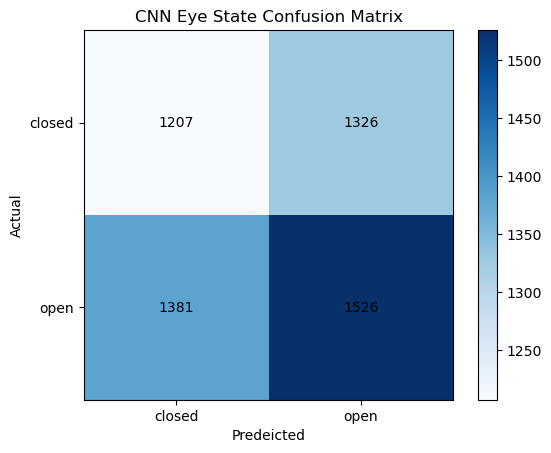

In [8]:
cm = confusion_matrix(true_labels,preds)
plt.imshow(cm, cmap="Blues")
plt.title("CNN Eye State Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], class_names)
plt.yticks([0,1], class_names)

for i in range(2):
    for j in range(2):
        plt.text(j,i, cm[i,j],ha='center',va='center')

plt.xlabel("Predeicted")
plt.ylabel("Actual")
plt.show()

<h1>Eye Aspect Ratio (EAR)</h1>

In [9]:
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    return (A + B) / (2.0 * C)

def crop_eye(gray, eye_points):
    h, w = gray.shape

    x_min = max(0, np.min(eye_points[:, 0]))
    y_min = max(0, np.min(eye_points[:, 1]))
    x_max = min(w, np.max(eye_points[:, 0]))
    y_max = min(h, np.max(eye_points[:, 1]))

    eye = gray[y_min:y_max, x_min:x_max]
    
    if eye.size == 0:
        return None

    return eye

In [10]:
#Load Face and Landmark Models

face_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor(r"C:\Users\Anuj\OneDrive\Desktop\Drowsiness Dataset\models\shape_predictor_68_face_landmarks.dat")

LEFT_EYE = list(range(36,42))
RIGHT_EYE = list(range(42,48))

<h2>Integeration of CNN and EAR</h2>

In [13]:
#load the cnn model
cnn_model = load_model(MODEL_PATH)

#webcam drowsiness detection
cap = cv2.VideoCapture(0)
drowsy_counter = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_detector(gray)

    for face in faces:
        landmarks = landmark_predictor(gray, face)
        coords = np.array([(p.x,p.y) for p in landmarks.parts() ])

        left_eye = coords[LEFT_EYE]
        right_eye = coords[RIGHT_EYE]

        #------ EAR----------
        ear = (eye_aspect_ratio(left_eye) + eye_aspect_ratio(right_eye)) / 2.0

        #-------- CNN (both eyes)--------
        preds = []
        for eye_points in [left_eye, right_eye]:
            eye_img = crop_eye(gray, eye_points)
            if eye_img is None:
                continue

            eye_img = cv2.resize(eye_img, (IMG_SIZE, IMG_SIZE))
            eye_img = eye_img / 255.0
            eye_img = eye_img.reshape(1, IMG_SIZE, IMG_SIZE, 1)

            pred = cnn_model.predict(eye_img, verbose=0)[0][0]
            preds.append(pred)

        if len(preds) == 0:
            continue

        cnn_pred = np.mean(preds)
        eye_state = "Open" if cnn_pred > 0.6 else "Closed"

        # ---- FINAL DECISION (CNN + EAR) ----
        if ear < EAR_THRESHOLD and eye_state == "Closed":
            drowsy_counter += 1
        else:
            drowsy_counter = 0

        if drowsy_counter >= DROWSY_FRAMES:
            cv2.putText(frame, "DROWSY ALERT!", (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

        # ---- DISPLAY ----
        final_state = "Closed" if ear < EAR_THRESHOLD else "Open"

        cv2.putText(frame, f"EAR: {ear:.2f} | Eye: {final_state}",
                    (20, frame.shape[0] - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    cv2.imshow("CNN + EAR Drowsiness Detection", frame)

    if cv2.waitKey(1) & 0xFF == 27: # ESC
        break
        
cap.release()
cv2.destroyAllWindows()